# ODE para crecimiento sublineal
lo siguiente es el sistema de crecimiento $$\dot{x}=\frac{x}{\theta}(1-x^{\theta})$$
el cual separaremos segun $\theta$ cuando cosntruyamos los procesos estocasticos correspondientes. Para $\theta>0$, Eq. (1) and (2) podemos escribir
$$
\dot{x}=\frac{x}{\theta}-\frac{x^{1+\theta}}{\theta}
$$
para $\theta=0$ como
$$
\dot{x}=x|\log (x)| \mathbb{1}_{x<1}-x|\log (x)| \mathbb{1}_{x>1},
$$
y para $\theta< 0$ como
$$
\dot{x}=\frac{x^{1+\theta}}{|\theta|}-\frac{x}{|\theta|} .
$$

Consideraremos $t=0$ y que $x_0=n_0/K > 0$, donde K es la capacidad de carga del sistema y $n_0$ como poblacion inicial. En lo siguiente calcularemos las soluciones numericas para el sistema inicial, los cuales mediante variaciones del parametro $Θ$ serán soluciones de las 3 ecuaciones deducidas.

In [ ]:
!pip install --upgrade "jax[cuda12]"

# Implementacion de JAX con compilacion JIT

Una de las formas más efectivas de acelerar este tipo de código en Python sin bajar a C++/CUDA es usar **JAX**. JAX es una biblioteca de Google para computación de alto rendimiento que puede compilar (transformar) código Python para que se ejecute de manera muy eficiente en la GPU.

*   **¿Cómo funciona?** Con su función `jax.jit`, JAX toma una función de Python (como tu bucle de simulación) y la compila en un único kernel de GPU optimizado. Esto elimina la sobrecarga del bucle de Python y optimiza las operaciones de memoria.
*   **Implementación:** Requeriría reescribir la función `simuladorTrayectoriasRuidosas_GPU` usando `jax.numpy` en lugar de `cupy` y reestructurar el bucle para que sea compatible con JIT (usando `jax.lax.while_loop`). El cambio es moderado y los beneficios de rendimiento pueden ser enormes.

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, lax, vmap, jit
from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import ticker
import seaborn as sns
from google.colab import files


from typing import Tuple, Callable, Dict, List, Optional, Union
import warnings
import time

# Configurar JAX para precisión de 64 bits
jax.config.update("jax_enable_x64", True)

print(f"Dispositivo JAX: {jax.default_backend()}")
print(f"Precisión activada: 64 bits")

Dispositivo JAX: gpu
Precisión activada: 64 bits


# Comprobacion numerica de las propos. 1.2, 1.3 & 1.4 mediante sim-//
Esto lo haremos mediante el analisis de los tiempos de extincion, los cuales graficaremos y estudiaremos su distribucion en el tiempo para entender en qué punto, por lejano que paresca, este ocurre y verifiquemos su existencia, inicialmente, para poblaciones pequeñas y sin eventos de nacimiento y muerte extras.

## Funciones de simulacion y calculo de estadisticas

### Construccion del Modelo

In [ ]:
def create_rate_functions(theta: float, alpha: float) -> Tuple[Callable, Callable]:
    """
    Genera funciones de tasas de nacimiento y muerte optimizadas y JIT-compiladas.

    Args:
        theta: Parámetro de crecimiento (-∞ < θ < ∞)
        alpha: Intensidad del ruido aditivo (α ≥ 0)

    Returns:
        Tupla (birth_fn, death_fn) de funciones JIT-compiladas
    """

    # Umbral numérico para proteger contra x→0 en régimen sublineal
    EPS = 1e-12

    if theta == 0:
        # ════════════════════════════════════════════════════════════════
        # RÉGIMEN GOMPERTZ (θ = 0)
        # ════════════════════════════════════════════════════════════════
        @jit
        def birth(x: float, K: float) -> float:
            """Tasa Gompertz: x|log(x)| con signo ajustado"""
            # xlogy maneja x=0 correctamente → 0
            term = jax.scipy.special.xlogy(x, x)
            return jnp.where(x < 1.0, -term, term) + alpha * x

        @jit
        def death(x: float, K: float) -> float:
            term = jax.scipy.special.xlogy(x, x)
            return jnp.where(x > 1.0, term, -term) + alpha * x

    elif theta > 0:
        # ════════════════════════════════════════════════════════════════
        # RÉGIMEN SUPERLINEAL/LOGÍSTICO (θ > 0)
        # ════════════════════════════════════════════════════════════════
        inv_theta = 1.0 / theta

        @jit
        def birth(x: float, K: float) -> float:
            """Tasa de nacimiento lineal con ruido aditivo"""
            return (x * inv_theta) + (alpha * x)

        @jit
        def death(x: float, K: float) -> float:
            """Tasa de muerte no lineal (densodependiente) con ruido"""
            # Optimización: evitar pow si θ=1 (caso logístico estándar)
            if theta == 1.0:
                return (x * x * inv_theta) + (alpha * x)
            return (jnp.power(x, 1.0 + theta) * inv_theta) + (alpha * x)

    else:  # theta < 0
        # ════════════════════════════════════════════════════════════════
        # RÉGIMEN SUBLINEAL (θ < 0) - CORRECCIÓN CRÍTICA
        # ════════════════════════════════════════════════════════════════
        abs_theta = jnp.abs(theta)
        inv_abs_theta = 1.0 / abs_theta
        exponent = 1.0 + theta  # Este será < 1 (fraccionario)

        @jit
        def birth(x: float, K: float) -> float:
            """
            Usamos un umbral EPS para evitar tasas erráticas cerca de cero.
            """
            # Protección contra x muy pequeños
            x_safe = jnp.maximum(x, EPS)
            return (jnp.power(x_safe, exponent) * inv_abs_theta) + (alpha * x)

        @jit
        def death(x: float, K: float) -> float:
            """Tasa de muerte lineal con ruido aditivo"""
            return (x * inv_abs_theta) + (alpha * x)

    return birth, death


In [ ]:
@partial(jit, static_argnums=(2, 3, 5, 6))
def simulate_single_trajectory(
    key: jax.random.PRNGKey,
    n0: float,
    theta: float,
    alpha: float,
    K: float,
    t_max: float,
    max_steps: int = 10_000_000
) -> Tuple[float, float]:
    """
    Simula una sola trayectoria del proceso de nacimiento-muerte usando
    el algoritmo exacto de Gillespie (SSA) hasta t_max o extinción.

    Args:
        key: Clave PRNG de JAX
        n0: Población inicial (como densidad x = n/K)
        theta: Parámetro de crecimiento
        alpha: Ruido aditivo
        K: Capacidad de carga
        t_max: Tiempo máximo de simulación
        max_steps: Límite de iteraciones para evitar loops infinitos

    Returns:
        (t_final, n_final): Tiempo final y población final
    """

    # Obtener funciones de tasa para este theta/alpha específico
    birth_fn, death_fn = create_rate_functions(theta, alpha)

    def condition(state):
        """Condición de continuación del loop"""
        t, n, step, _ = state
        # Continuar si: t < t_max AND n > 0 AND step < max_steps
        return (t < t_max) & (n > 0.0) & (step < max_steps)

    def body(state):
        """Paso de simulación de Gillespie"""
        t, n, step, key = state

        # Generar nueva clave y números aleatorios
        key, subkey = random.split(key)
        u = random.uniform(subkey, (2,))  # [u_time, u_event]

        # Calcular tasas (n ya es densidad x = n/K)
        lambda_birth = birth_fn(n, K) * K  # Escalar a población absoluta
        mu_death = death_fn(n, K) * K
        total_rate = lambda_birth + mu_death

        # Protección numérica contra tasa total = 0
        safe_rate = jnp.maximum(total_rate, 1e-20)

        # Tiempo hasta próximo evento: dt ~ Exponential(total_rate)
        dt = -jnp.log(u[0]) / safe_rate
        t_new = t + dt

        # Selección de evento: nacimiento si u < λ/(λ+μ)
        # Implementación branchless: evita if/else para eficiencia GPU
        is_birth = (u[1] * safe_rate) < lambda_birth
        delta = jnp.where(is_birth, 1.0, -1.0)

        # Actualizar población (como densidad)
        n_new = n + (delta / K)
        n_new = jnp.maximum(n_new, 0.0)  # Clamp para evitar negativos

        return (t_new, n_new, step + 1, key)

    # Estado inicial: (tiempo, población_densidad, num_pasos, clave)
    init_state = (0.0, n0, 0, key)

    # Ejecutar simulación
    final_state = lax.while_loop(condition, body, init_state)

    return final_state[0], final_state[1]  # (t_final, n_final)

In [ ]:
def simulate_batch(
    key: jax.random.PRNGKey,
    N: int,
    n0: float,
    theta: float,
    alpha: float,
    K: float,
    t_max: float,
    batch_size: int = 50_000,
    max_steps: int = 10_000_000
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Simula N trayectorias en paralelo usando batching para gestionar memoria GPU.

    Args:
        key: Clave PRNG base
        N: Número total de trayectorias
        n0, theta, alpha, K, t_max: Parámetros del modelo
        batch_size: Trayectorias por batch (ajustar según VRAM disponible)
        max_steps: Límite de pasos por trayectoria

    Returns:
        (times, finals): Arrays con tiempos finales y poblaciones finales
    """

    all_times = []
    all_finals = []

    N = int(N)
    if N == 0:
        return jnp.array([]), jnp.array([])

    num_batches = (N + batch_size - 1) // batch_size

    # Función vectorizada sobre el eje 0 (keys)
    sim_vmap = vmap(
        simulate_single_trajectory,
        in_axes=(0, None, None, None, None, None, None)
    )

    for i in range(num_batches):
        current_batch_size = min(batch_size, N - i * batch_size)
        if current_batch_size <= 0:
            break

        # Generar claves independientes para cada trayectoria del batch
        key, batch_key = random.split(key)
        batch_keys = random.split(batch_key, current_batch_size)

        # Ejecutar batch completo en paralelo
        batch_times, batch_finals = sim_vmap(
            batch_keys, n0, theta, alpha, K, t_max, max_steps
        )

        all_times.append(batch_times)
        all_finals.append(batch_finals)

    # Concatenar resultados
    times = jnp.concatenate(all_times) if all_times else jnp.array([])
    finals = jnp.concatenate(all_finals) if all_finals else jnp.array([])

    return times, finals

### Estadisticas de extincion

In [ ]:
def compute_extinction_statistics(
    times: jnp.ndarray,
    finals: jnp.ndarray,
    theta: float,
    alpha: float,
    K: float
) -> Dict:
    """
    Calcula estadísticas descriptivas SOLO para trayectorias extintas.

    Args:
        times: Tiempos finales de todas las trayectorias
        finals: Poblaciones finales (0 = extinción)
        theta, alpha, K: Parámetros del modelo

    Returns:
        Diccionario con estadísticas de extinción
    """

    # Máscara booleana: True solo para extinciones reales
    is_extinct = (finals == 0.0)
    count_extinct = jnp.sum(is_extinct)

    # Reemplazar no-extintos con NaN para cálculos estadísticos
    valid_times = jnp.where(is_extinct, times, jnp.nan)

    return {
        'mean': float(jnp.nanmean(valid_times)),
        'std': float(jnp.nanstd(valid_times)),
        'variance': float(jnp.nanvar(valid_times)),
        'count': int(count_extinct),
        'times_extinct': valid_times, # This will remain a jnp.ndarray
        'theta': float(theta),
        'alpha': float(alpha),
        'K': float(K),
        'total_simulations': len(times),
        'extinction_rate': float(count_extinct / len(times)) if len(times) > 0 else 0.0
    }

### Estimacion de la constante V

In [ ]:
def compute_theoretical_extinction_probability(theta: float, alpha: float) -> float:
    """
    Calcula la probabilidad asintótica de extinción según la teoría.

    Para θ > 0 (régimen superlineal/logístico):
        P_ext(∞) = α·θ / (1 + α·θ)
    Args:
        theta: Parámetro de crecimiento (debe ser > 0 para esta fórmula)
        alpha: Intensidad del ruido aditivo

    Returns:
        Probabilidad teórica en [0, 1]
    """
    if theta <= 0:
        warnings.warn(
            f"La fórmula α·θ/(1+α·θ) solo es válida para θ > 0. "
            f"Para θ={theta}, se requiere análisis de régimen sublineal."
        )
        return np.nan

    # Fórmula principal
    numerator = alpha * theta
    denominator = 1.0 + alpha * theta

    return numerator / denominator

In [ ]:
def estimate_V_adaptive(
    times: jnp.ndarray,
    finals: jnp.ndarray,
    K: float,
    theta: float,
    alpha: float,
    min_extinctions: int = 100,
    grid_refinement: int = 200,
    search_width: float = 0.8,
    verbose: bool = True
) -> Dict[str, Union[float, str]]:
    """
    Estima el parámetro V usando un enfoque adaptativo de dos fases:

    FASE 1: Heurística inicial basada en datos empíricos
    ----------------------------------------------------
    Calcula V_init = ln(mean_T_ext) / K, que proporciona una primera
    aproximación del orden de magnitud correcto. Esta estimación proviene
    de tomar logaritmos en ambos lados de T ~ exp(VK).

    FASE 2: Refinamiento mediante búsqueda en grid adaptativo
    ----------------------------------------------------------
    Construye un grid centrado en V_init y busca el valor óptimo que minimiza
    el error absoluto entre la proporción observada de extinciones antes de
    t_limit = exp(VK) y la probabilidad teórica α·θ / (1 + α·θ)

    VALIDACIÓN Y CASOS LÍMITE:
    --------------------------
    - Si no hay extinciones, retorna status="No_Extinction" sin intentar calcular V
    - Si hay pocas extinciones (<min_extinctions), marca status="Low_Statistics"
    - Advierte si el régimen es potencialmente no-metaestable (θ<0, α alto)

    Args:
        times: Array de tiempos finales de todas las trayectorias
        finals: Array de poblaciones finales (0 = extinción)
        K: Capacidad de carga del sistema
        theta: Parámetro de crecimiento poblacional
        alpha: Intensidad del ruido aditivo
        min_extinctions: Umbral mínimo de extinciones para considerar la estimación confiable
        grid_refinement: Número de puntos en el grid de búsqueda adaptativo
        search_width: Ancho relativo del intervalo de búsqueda (0.8 = ±40% de V_init)
        verbose: Si imprimir información diagnóstica

    Returns:
        Diccionario con los siguientes campos:
        - 'mean_extinction_time': Tiempo medio de extinción observado
        - 'median_extinction_time': Mediana de tiempos de extinción
        - 'extinction_rate': Proporción de trayectorias que se extinguieron
        - 'num_extinctions': Número absoluto de extinciones observadas
        - 'V_init_heuristic': Estimación inicial de V (ln(T_mean)/K)
        - 'V_estimated': Valor optimizado de V (None si no aplicable)
        - 'V_error': Error mínimo alcanzado en la optimización
        - 't_limit_optimal': Tiempo límite exp(V_optimal * K)
        - 'observed_prob_at_optimal': Proporción observada en t_limit_optimal
        - 'theoretical_prob': Probabilidad teórica (siempre 1-e^(-1))
        - 'status': Código de estado ("Converged", "No_Extinction", "Low_Statistics", "Stable_Regime")
        - 'warning': Mensaje de advertencia si aplica
    """

    # ========================================================================
    # PASO 0: Validación inicial de entrada
    # ========================================================================

    if len(times) == 0 or len(finals) == 0:
        return _create_invalid_result(
            status="Invalid_Input",
            warning="Arrays de entrada vacíos",
            theta=theta, alpha=alpha, K=K
        )

    # ========================================================================
    # PASO 1: Identificar trayectorias extintas
    # ========================================================================

    extinction_mask = (finals == 0.0)
    num_extinctions = int(jnp.sum(extinction_mask))
    total_trajectories = len(times)
    extinction_rate = num_extinctions / total_trajectories

    if verbose:
        print(f"\n{'='*70}")
        print(f"ANÁLISIS DE EXTINCIÓN: θ={theta}, α={alpha}, K={K:.2e}")
        print(f"{'='*70}")
        print(f"Trayectorias totales: {total_trajectories:,}")
        print(f"Extinciones observadas: {num_extinctions:,} ({extinction_rate:.2%})")

    # ========================================================================
    # PASO 2: Manejo del caso sin extinciones
    # ========================================================================

    if num_extinctions == 0:
        if verbose:
            print(f"⚠ ADVERTENCIA: No se observaron extinciones en el horizonte temporal.")
            print(f"   Esto es común para θ < -1 o K muy grande.")
            print(f"   El parámetro V no puede estimarse sin datos de extinción.")

        return _create_invalid_result(
            status='No_Extinction',
            warning='Régimen ultra-estable: no se observaron extinciones',
            theta=theta, alpha=alpha, K=K
        )

    # ========================================================================
    # PASO 3: Calcular estadísticas descriptivas sobre extinciones
    # ========================================================================

    extinction_times = times[extinction_mask]
    mean_T_ext = float(jnp.mean(extinction_times))
    median_T_ext = float(jnp.median(extinction_times))

    if verbose:
        print(f"\nEstadísticas de Tiempos de Extinción:")
        print(f"  Media: {mean_T_ext:.4e}")
        print(f"  Mediana: {median_T_ext:.4e}")
        print(f"  Desv. Est.: {float(jnp.std(extinction_times)):.4e}")

    # ========================================================================
    # PASO 4: Advertencia sobre régimen potencialmente no-metaestable
    # ========================================================================

    warning_message = None
    status_flag = "Converged"  # Valor por defecto, se actualizará si hay problemas

    # Criterio 1: θ negativo con α alto sugiere dominancia del ruido
    if theta < 0 and alpha > 50:
        warning_message = (
            f"ADVERTENCIA: θ={theta} < 0 con α={alpha} alto. "
            f"El ruido aditivo puede dominar sobre la dinámica sublineal, "
            f"violando la suposición de distribución exponencial para T_ext."
        )
        if verbose:
            print(f"\n⚠ {warning_message}")

    # Criterio 2: Tasa de extinción muy baja
    if extinction_rate < 0.01:
        warning_message = (
            warning_message or "" +
            f" | Tasa de extinción muy baja ({extinction_rate:.3%}). "
            f"El sistema es casi estable, V podría no tener interpretación física clara."
        )
        status_flag = "Stable_Regime"
        if verbose:
            print(f"⚠ Tasa de extinción < 1%: régimen potencialmente estable.")

    # Criterio 3: Estadísticas insuficientes
    if num_extinctions < min_extinctions:
        warning_message = (
            warning_message or "" +
            f" | Solo {num_extinctions} extinciones (mínimo recomendado: {min_extinctions}). "
            f"La estimación de V tiene alta incertidumbre."
        )
        status_flag = "Low_Statistics"
        if verbose:
            print(f"⚠ Estadísticas bajas: {num_extinctions} < {min_extinctions} extinciones.")

    # ========================================================================
    # PASO 5: FASE 1 - Estimación heurística inicial
    # ========================================================================

    # Fórmula: Si T ~ exp(VK), entonces ln(T) ~ VK, por lo tanto V ~ ln(T)/K
    # Usamos la media de tiempos de extinción como estimador robusto

    if mean_T_ext <= 0:
        # Caso patológico: tiempos negativos o cero (no debería ocurrir)
        return _create_invalid_result(
            status="Invalid_Data",
            warning="Tiempos de extinción no positivos detectados",
            theta=theta, alpha=alpha, K=K
        )

    V_init = np.log(mean_T_ext) / K

    if verbose:
        print(f"\n{'─'*70}")
        print(f"FASE 1: Estimación Heurística Inicial")
        print(f"{'─'*70}")
        print(f"V_init = ln(T_mean) / K = ln({mean_T_ext:.4e}) / {K:.2e}")
        print(f"V_init = {V_init:.6e}")
        print(f"Esto implica t_limit ≈ exp({V_init:.6e} × {K:.2e}) = {np.exp(V_init * K):.4e}")

    # ========================================================================
    # PASO 6: FASE 2 - Refinamiento mediante grid adaptativo
    # ========================================================================

    if verbose:
        print(f"\n{'─'*70}")
        print(f"FASE 2: Refinamiento con Grid Adaptativo (MEA)")
        print(f"{'─'*70}")

    # Construir grid centrado en V_init con ancho adaptativo
    # El factor search_width controla qué tan lejos exploramos
    # Ejemplo: search_width=0.8 significa buscar en [0.6*V_init, 1.4*V_init]

    V_min = V_init * (1.0 - search_width / 2.0)
    V_max = V_init * (1.0 + search_width / 2.0)

    # Protección contra rangos degenerados
    if V_min <= 0:
        V_min = V_init * 0.1  # Al menos 10% del valor inicial

    V_candidates = np.linspace(V_min, V_max, grid_refinement)

    if verbose:
        print(f"Rango de búsqueda: [{V_min:.6e}, {V_max:.6e}]")
        print(f"Número de puntos del grid: {grid_refinement}")

    # Probabilidad teórica objetivo
    P_asymptotic_theory = compute_theoretical_extinction_probability(theta, alpha)

    # Arrays para almacenar resultados de la búsqueda
    errors = np.zeros(grid_refinement)
    observed_probs = np.zeros(grid_refinement)

    # Evaluar cada candidato
    for i, V_candidate in enumerate(V_candidates):
        t_limit = np.exp(V_candidate * K)

        # Contar extinciones antes de t_limit
        extinct_before_limit = jnp.sum((extinction_times < t_limit))
        P_observed = float(extinct_before_limit) / total_trajectories

        # Calcular error absoluto
        error = np.abs(P_observed - P_asymptotic_theory)

        errors[i] = error
        observed_probs[i] = P_observed

    # Encontrar el mínimo
    idx_optimal = np.argmin(errors)
    V_optimal = float(V_candidates[idx_optimal])
    error_min = float(errors[idx_optimal])
    P_obs_optimal = float(observed_probs[idx_optimal])
    t_limit_optimal = float(np.exp(V_optimal * K))

    if verbose:
        print(f"\nResultado de la Optimización:")
        print(f"  V_optimal = {V_optimal:.6e}")
        print(f"  Error mínimo = {error_min:.6f}")
        print(f"  t_limit = exp(VK) = {t_limit_optimal:.4e}")
        print(f"  P_observada = {P_obs_optimal:.4f}")
        print(f"  P_teórica = {P_asymptotic_theory:.4f}")
        print(f"  Diferencia respecto a V_init = {100*(V_optimal/V_init - 1):.2f}%")

    # ========== PASO 7A - Validación Asintótica ==========

    # Calcular la probabilidad empírica (simplemente el extinction_rate)
    P_asymptotic_observed = extinction_rate

    # Calcular el error entre teoría y observación
    if not np.isnan(P_asymptotic_theory):
        asymptotic_error = abs(P_asymptotic_observed - P_asymptotic_theory)

        if verbose:
            print(f"\n{'─'*70}")
            print(f"VALIDACIÓN DE PROBABILIDAD ASINTÓTICA")
            print(f"{'─'*70}")
            print(f"P_ext teórica = α·θ/(1+α·θ) = {alpha}·{theta}/(1+{alpha}·{theta})")
            print(f"              = {P_asymptotic_theory:.4f}")
            print(f"P_ext observada = {P_asymptotic_observed:.4f}")
            print(f"Error absoluto = {asymptotic_error:.4f}")
            print(f"Error relativo = {100*asymptotic_error/P_asymptotic_theory:.2f}%")

            # Interpretación del ajuste
            if asymptotic_error < 0.05:
                print("✓ Excelente acuerdo con la teoría")
            elif asymptotic_error < 0.10:
                print("✓ Buen acuerdo, desviaciones probablemente estadísticas")
            else:
                print("⚠ Desviación significativa. Posibles causas:")
                print("  - Horizonte temporal T_max insuficiente (no alcanzaste t→∞)")
                print("  - Efectos de tamaño finito (K no suficientemente grande)")
                print("  - Violación de las suposiciones del modelo")
    else:
        asymptotic_error = np.nan
        if verbose:
            print(f"\n⚠ Validación asintótica no disponible para θ={theta} ≤ 0")

    # ========================================================================
    # PASO 7: Construir diccionario de resultados
    # ========================================================================

    results = {
        'mean_extinction_time': mean_T_ext,
        'median_extinction_time': median_T_ext,
        'extinction_rate': extinction_rate,
        'num_extinctions': num_extinctions,
        'V_init_heuristic': float(V_init),
        'V_estimated': V_optimal,
        'V_error': error_min,
        't_limit_optimal': t_limit_optimal,
        'observed_prob_at_optimal': P_obs_optimal,
        'theoretical_prob': P_asymptotic_theory,
        'status': status_flag,
        'warning': warning_message,
        # Datos adicionales para análisis posterior
        'V_candidates': V_candidates,
        'errors_grid': errors,
        'observed_probs_grid': observed_probs,
        'P_asymptotic_observed': P_asymptotic_observed,
        # 'P_asymptotic_theory': P_asymptotic_theory,
        'asymptotic_error': asymptotic_error,
        'theta': theta,
        'alpha': alpha,
        'K': K
    }

    if verbose:
        print(f"\nEstado final: {status_flag}")
        if warning_message:
            print(f"Advertencias: {warning_message}")
        print(f"{'='*70}\n")

    return results

In [ ]:
def _create_invalid_result(status: str, warning: str, theta: float = np.nan, alpha: float = np.nan, K: float = np.nan) -> Dict:
    """
    Crea un diccionario de resultados para casos donde no se puede estimar V.
    Esto evita excepciones y permite al usuario manejar casos límite elegantemente.
    """
    return {
        'mean_extinction_time': np.nan,
        'median_extinction_time': np.nan,
        'extinction_rate': 0.0,
        'num_extinctions': 0,
        'V_init_heuristic': np.nan,
        'V_estimated': None,
        'V_error': np.nan,
        't_limit_optimal': np.nan,
        'observed_prob_at_optimal': np.nan,
        'theoretical_prob': np.nan, # Keep this as the primary key
        'status': status,
        'warning': warning,
        'theta': theta,
        'alpha': alpha,
        'K': K,
        # Remove 'P_asymptotic_theory' as it's a duplicate/inconsistent name
        'P_asymptotic_observed': np.nan,
        'asymptotic_error': np.nan
    }

In [ ]:
def batch_estimate_V(
    simulation_results: Dict[str, Tuple[jnp.ndarray, jnp.ndarray]],
    parameters: Dict[str, Dict[str, float]],
    **kwargs
) -> Dict[str, Dict]:
    """
    Procesa múltiples resultados de simulación en batch.

    Args:
        simulation_results: Dict con claves descriptivas y valores (times, finals)
        parameters: Dict con claves iguales a simulation_results y valores
                   siendo dicts con 'K', 'theta', 'alpha'
        **kwargs: Argumentos adicionales para estimate_V_adaptive

    Returns:
        Diccionario de resultados con las mismas claves
    """
    results = {}

    print(f"\n{'='*80}")
    print(f"PROCESAMIENTO EN BATCH DE {len(simulation_results)} CONFIGURACIONES")
    print(f"{'='*80}")

    for idx, (key, (times, finals)) in enumerate(simulation_results.items(), 1):
        params = parameters.get(key)

        if params is None:
            warnings.warn(f"Parámetros faltantes para {key}, saltando...")
            continue

        K = params['K']
        theta = params['theta']
        alpha = params['alpha']

        print(f"\n[{idx}/{len(simulation_results)}] Procesando: {key}")

        results[key] = estimate_V_adaptive(
            times, finals, K, theta, alpha,
            verbose=kwargs.get('verbose', False),
            **{k: v for k, v in kwargs.items() if k != 'verbose'}
        )

    print(f"\n{'='*80}")
    print(f"PROCESAMIENTO COMPLETADO")
    print(f"{'='*80}\n")

    return results

### Ploteo

In [ ]:
def plot_extinction_histogram(times, stad, theta_labels, theta_display_value, K, alpha):

    escala = 100
    tics_y = ticker.FuncFormatter(lambda y, pos:'{:.2f}'.format(y*escala))

    plt.hist(times, bins=75, density=True, alpha=0.7, label='Extinction Times')

    # Ajuste exponencial teórico: lambda = 1 / media
    loc, scale = stats.expon.fit(times)
    x = np.linspace(min(times), max(times), 100)
    pdf = stats.expon.pdf(x, loc, scale)

    plt.plot(x, pdf, 'r-', lw=2, label=f'Ajuste Exp (Media={scale:.2e})')

    # Add statistics from the 'stad' dictionary as a legend
    stats_text = f"Trayectorias: {int(stad['count'])}\nMean: {stad['mean']:.2f}\nVariance: {jax.device_put(stad['variance'], jax.devices('cpu')[0]).item():.2f}\nStd Dev: {jax.device_put(stad['std'], jax.devices('cpu')[0]).item():.2f}"
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.xlabel("Tiempo de extinción")
    plt.ylabel(f"Densidad (x{escala})")
    plt.title(f"Distribución de tiempos de extinción de {theta_labels}\n( K={K}, alpha={alpha})")
    plt.gca().yaxis.set_major_formatter(tics_y) # Apply the tics_y formatter

    plt.legend()
    plt.savefig(f"histExt_theta{theta_display_value}_alpha{alpha}_K{K:.0e}.png") # Save the plot as a PNG file
    print("El archivo 'extinction_histogram.png' ha sido creado correctamente.") # Confirmation message
    plt.show()

In [ ]:
def plot_V_estimation_diagnostics(
    results: Dict,
    save_path: Optional[str] = None
) -> plt.Figure:
    """
    Genera un dashboard completo de diagnóstico para la estimación de V.

    Este gráfico de 3 paneles te permite evaluar visualmente:
    1. La curva de error vs V candidato (para ver si el mínimo es claro)
    2. La comparación entre probabilidad observada y teórica
    3. La ubicación de V_init vs V_optimal

    Args:
        results: Diccionario retornado por estimate_V_adaptive
        save_path: Ruta opcional para guardar la figura

    Returns:
        Objeto Figure de matplotlib
    """

    # Verificar que tenemos datos válidos para graficar
    if results['status'] == 'No_Extinction' or results['V_estimated'] is None:
        print(f"No se puede graficar: {results['status']}")
        print(f"Motivo: {results['warning']}")
        return None

    # fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    V_cand = results['V_candidates']
    errors = results['errors_grid']
    obs_probs = results['observed_probs_grid']
    V_init = results['V_init_heuristic']
    V_opt = results['V_estimated']
    P_theo = results['theoretical_prob']


    # ========================================================================
    # Panel 2: Probabilidad observada vs V
    # ========================================================================

    ax2 = axes[0]
    ax2.plot(V_cand, obs_probs, 'b-', linewidth=2, label='P observada')
    ax2.axhline(P_theo, color='red', linestyle='--', linewidth=2,
                label=f'P teórica = {P_theo:.4f}')
    ax2.axvline(V_opt, color='orange', linestyle=':', alpha=0.7,
                label=f'V óptimo')

    ax2.set_xlabel('Candidato V', fontsize=12)
    ax2.set_ylabel('P(T_ext < exp(VK))', fontsize=12)
    ax2.set_title('Convergencia a Probabilidad Teórica', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)

    # ========================================================================
    # Panel 3: Comparación V_init vs V_optimal
    # ========================================================================

    ax3 = axes[1]

    # Crear gráfico de barras comparativo
    categories = ['V_init\n(Heurística)', 'V_optimal\n(MEA)']
    values = [V_init, V_opt]
    colors = ['orange', 'red']

    bars = ax3.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')

    # Anotar los valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.5e}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Mostrar diferencia porcentual
    diff_percent = 100 * (V_opt / V_init - 1)
    ax3.text(0.5, 0.95, f'Diferencia: {diff_percent:+.2f}%',
            transform=ax3.transAxes, ha='center', va='top',
            fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax3.set_ylabel('Valor de V', fontsize=12)
    ax3.set_title('Comparación de Estimaciones', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

    # ========================================================================
    # Título general con información del experimento
    # ========================================================================

    fig.suptitle(
        f'Diagnóstico de Estimación de V | '
        f'Extinciones: {results["num_extinctions"]:,} ({results["extinction_rate"]:.2%}) | '
        f'Estado: {results["status"]}',
        fontsize=14, fontweight='bold', y=1.02
    )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Figura guardada en: {save_path}")

    return fig

### Funciones especificas para la aproximacion de V para thetas negativos
En el caso de los parametros sublineales hay que tener un cuidado mas fino, puesto que sus tiempos de extincion exponenciales generan problemas al momento de estimar un valor de $V$ mediante fuerza bruta como lo hemos estado haciendo

In [ ]:
def run_sublinear_scaling_experiment(
    N_traj,
    base_t_max,
    K_values,
    thetas,
    alpha,
    seed=42
):
    """
    Ejecuta simulaciones masivas variando K para estudiar la ley de escalamiento
    T ~ exp(VK) en el régimen sublineal.

    Args:
        thetas: Lista de valores de theta (deben ser <= 0).
        alpha: Ruido aditivo (fijo).
        K_values: Lista de capacidades de carga pequeñas.
        N_traj: Número de trayectorias por configuración (M en el plan).
        base_t_max: Tiempo máximo base (se ajusta dinámicamente si es necesario).
        seed: Semilla aleatoria.

    Returns:
        results_df: DataFrame con resumen estadístico (K, theta, Mean_T, etc).
        raw_data: Diccionario con los tiempos crudos para análisis de distribución.
    """

    key = random.PRNGKey(seed)
    results_list = []
    raw_data = {}

    print(f"{'='*60}")
    print(f"INICIANDO EXPERIMENTO DE ESCALAMIENTO SUBLINEAL (RTM)")
    print(f"Configuración: Alpha={alpha}, Trayectorias={N_traj}")
    print(f"{'='*60}\n")

    for theta in thetas:
        print(f"--> Procesando Theta = {theta}")

        for i, K in enumerate(K_values):
            # 1. Configuración de parámetros

            # Ajuste dinámico de t_max: Para K mayores, necesitamos más tiempo.
            # Heurística simple: aumentamos t_max un factor por cada paso de K
            # para asegurar que capturemos los eventos raros sin cortar la cola.
            current_t_max = base_t_max * (1.5 ** i)

            # Generar subkey
            key, subkey = random.split(key)

            # 2. Ejecución (Usando tu función optimizada existente)
            start_time = time.time()
            times, finals = simulate_batch(
                subkey, N_traj, x0, theta, alpha, float(K), current_t_max
            )
            elapsed = time.time() - start_time

            # 3. Recolección de Estadísticas
            stats_dict = compute_extinction_statistics(times, finals, theta, alpha, K)

            # Guardar datos crudos para el análisis de transición de fase (Fase 3)
            # Solo guardamos los tiempos de las que sí se extinguieron
            raw_data[(theta, K)] = stats_dict['times_extinct']

            # Registro de resultados
            mean_time = stats_dict['mean']
            var_time = stats_dict['variance']
            extinction_count = stats_dict['count']

            # Verificación de calidad de datos
            if extinction_count < N_traj * 0.1:
                print(f"   [ALERTA] K={K}: Pocas extinciones ({extinction_count}). Aumentar t_max.")

            results_list.append({
                'theta': theta,
                'K': K,
                'mean_extinction_time': mean_time,
                'log_mean_time': np.log(mean_time) if mean_time > 0 else np.nan,
                'variance': var_time,
                'extinction_rate': extinction_count / N_traj,
                't_max_used': current_t_max
            })

            print(f"   K={K:2d} | T_mean={mean_time:.2e} | Extintos={extinction_count}/{N_traj} | WallTime={elapsed:.2f}s")

    results_df = pd.DataFrame(results_list)
    return results_df, raw_data

In [ ]:
def analyze_scaling_law(results_df):
    """
    Realiza el ajuste lineal ln(T) = V*K + C para estimar V.
    Genera gráficos de la ley de escalamiento.
    """
    unique_thetas = results_df['theta'].unique()

    fig, ax = plt.subplots(figsize=(10, 6))

    estimates = {}

    for theta in unique_thetas:
        subset = results_df[results_df['theta'] == theta].dropna()

        if len(subset) < 2:
            print(f"Datos insuficientes para theta={theta}")
            continue

        X = subset['K'].values
        Y = subset['log_mean_time'].values

        # Regresión Lineal
        slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

        # La pendiente es nuestra estimación de V
        V_estimated = slope
        estimates[theta] = V_estimated

        # Graficar
        ax.plot(X, Y, 'o', label=f'Simulación $\theta={theta}$')
        ax.plot(X, slope*X + intercept, '--',
                label=f'Ajuste: $V \\approx {V_estimated:.4f}$ ($R^2={r_value**2:.4f}$)')

    ax.set_xlabel('Capacidad de Carga ($K$)', fontsize=12)
    ax.set_ylabel(r'$\ln($Tiempo Medio de Extinci\u00f3n$)$', fontsize=12)
    ax.set_title(r'Verificaci\u00f3n de Ley de Escalamiento $T \sim e^{VK}$', fontsize=14)
    ax.grid(True, which="both", ls="-", alpha=0.5)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return estimates

In [ ]:
def verify_metastability(raw_data, theta_target, K_target):
    """
    Verifica si los tiempos de extinción siguen una distribución exponencial
    mediante Histograma y Q-Q Plot.
    """
    print(f"\n--- [2] Test de Metaestabilidad (Theta={theta_target}, K={K_target}) ---")

    try:
        times_raw = raw_data[(theta_target, K_target)]
        # Filter out NaN values
        times = times_raw[~jnp.isnan(times_raw)]
        if len(times) == 0:
            print(f"No hay tiempos de extinción válidos para Theta={theta_target} y K={K_target}. Saltando gráficos.")
            return # Return early if no valid extinction times
        times = np.array(times) # Convert JAX array to numpy for scipy/matplotlib
    except KeyError:
        print(f"Error: No hay datos simulados para Theta={theta_target} y K={K_target}. Saltando gráficos.")
        return
    except Exception as e:
        print(f"Error procesando datos para Theta={theta_target}, K={K_target}: {e}. Saltando gráficos.")
        return

    # 1. Histograma de Tiempos Crudos
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
        # Normalizamos para comparar con la PDF teórica
    count, bins, ignored = plt.hist(times, bins=50, density=True, alpha=0.6, color='green', label='Simulación')

    # Ajuste exponencial teórico: lambda = 1 / media
    loc, scale = stats.expon.fit(times)
    x = np.linspace(min(times), max(times), 100)
    pdf = stats.expon.pdf(x, loc, scale)

    plt.plot(x, pdf, 'r-', lw=2, label=f'Ajuste Exp (Media={scale:.2e})')
    plt.xlabel('Tiempo de Extinción ($T$)', fontsize=12)
    plt.ylabel('Densidad', fontsize=12)
    plt.title(f'Histograma de Tiempos de extincion de θ ={theta_target}\nCapacidad K={K_target}', fontsize=14)
    plt.legend()

    # 2. Q-Q Plot (Quantile-Quantile)
    # plt.subplot(1, 2, 2)
    # stats.probplot(times, dist="expon", plot=plt)
    # plt.title('Gráfico Q-Q vs Exponencial', fontsize=14)

    plt.tight_layout()
    plt.show()

    print("Criterio de Aceptación:")
    print("1. Histograma: Debe decaer exponencialmente desde t=0 (cola larga). NO debe ser campana.")
    print("2. Q-Q Plot: Los puntos azules deben seguir la línea roja recta.")

## Variables de simulacion en paralelo
Los parametros a simular son:
* Parametros experimentales: $\theta_{SubLG2}=-2\text{ y }\theta_{SupLogG}=2$
* Parametros utiles: $\theta_{SubLG1}=-0.85\text{, }\theta_{GompG}=0\text{, }\theta_{SupLG}=0.64\text{ y }\theta_{LogG}=1$

Luego, consideraremos $K$ la capacidad de carga en los valores $\{10^3,10^4,10^5,10^6\}$, tomaremos un horizonte temporal maximo se $T=10^8$ y un numero de trayectorias a simular de $N=5\times10^5$.

Por ultimo, tomaremos una variedad de valores de $\alpha$ para medir el impacto de este en las extinciones y formas de las curvas $\{1, 50,100,500\}$



In [ ]:
# Valores de theta a investigar
theta_values = [
                # 2.0,
                1.0,
                # 0.0,
                0.64,
                -0.5,
                -1.5,
                # 2.0
                ]
theta_labels = [
    # "θ = 2.0 (SuperLineal Extremo)",
    "θ = 1.0 (Logístico)",
    # "θ = 0.0 (Gompertz)",
    "θ = 0.64 (Superlineal)",
    "θ = -0.5 (Sublineal )",
    "θ = -1.0 (Sublineal Crítico)",
    # "θ = -2.0 (Extremadamente Sublineal)"
]

In [ ]:
# Variables de simulacion
key = random.PRNGKey(202) # Clave PRNG para inicializar el generador de números aleatorios de JAX
N = 100              # Número de trayectorias a simular
t_max = 1.0e50             # Tiempo máximo de simulación (horizonte temporal)
K = 1.0e2                # Capacidad de carga del sistema
x0 = 1/K               # Población inicial (como densidad x = n/K)
th = 1.0              # Parámetro theta de crecimiento (aquí, theta=1.0 para el régimen logístico)
al = 10.0              # Parámetro de B&D añadidos

## Ejecucion de simulaciones para $\theta>0$

### Simulaciones para un $\theta$ particular
En esta subseccion es posible la simulacion de trayectorias del proceso B&D que para hacerse una idea de como es el comportamiento de este tipo de trayectorias


In [ ]:
# Después de correr tu simulación
times, finals = simulate_batch(key, N, x0, th,
                                al, K, t_max)

# calcular las estadisticas descriptivas
stats = compute_extinction_statistics(times, finals, th, al, K)

# Estimar V con el método optimizado
results = estimate_V_adaptive(
    times, finals,
    K,
    th,
    al,
    min_extinctions=100,   # Ajusta según tus necesidades
    grid_refinement=200,   # Más puntos = mayor precisión pero más lento
    search_width=0.8,      # Ancho del intervalo de búsqueda
    verbose=True           # Para debugging
)


ANÁLISIS DE EXTINCIÓN: θ=0.64, α=100.0, K=1.00e+06
Trayectorias totales: 50,000
Extinciones observadas: 42,356 (84.71%)

Estadísticas de Tiempos de Extinción:
  Media: 1.5183e+12
  Mediana: 7.5196e-03
  Desv. Est.: 5.4868e+12

──────────────────────────────────────────────────────────────────────
FASE 1: Estimación Heurística Inicial
──────────────────────────────────────────────────────────────────────
V_init = ln(T_mean) / K = ln(1.5183e+12) / 1.00e+06
V_init = 2.804860e-05
Esto implica t_limit ≈ exp(2.804860e-05 × 1.00e+06) = 1.5183e+12

──────────────────────────────────────────────────────────────────────
FASE 2: Refinamiento con Grid Adaptativo (MEA)
──────────────────────────────────────────────────────────────────────
Rango de búsqueda: [1.682916e-05, 3.926804e-05]
Número de puntos del grid: 200

Resultado de la Optimización:
  V_optimal = 3.227703e-05
  Error mínimo = 0.137495
  t_limit = exp(VK) = 1.0417e+14
  P_observada = 0.8471
  P_teórica = 0.9846
  Diferencia respecto a

In [ ]:
filename_EV = f"estV_theta{th}_alpha{al}_K{K:.0e}.png"

✓ Figura guardada en: estV_theta0.64_alpha100.0_K1e+06.png
Tiempo medio de extinción: 1.5183e+12
V heurístico: 2.804860e-05
V optimizado: 3.227703e-05
Mejora: 13.75% de error


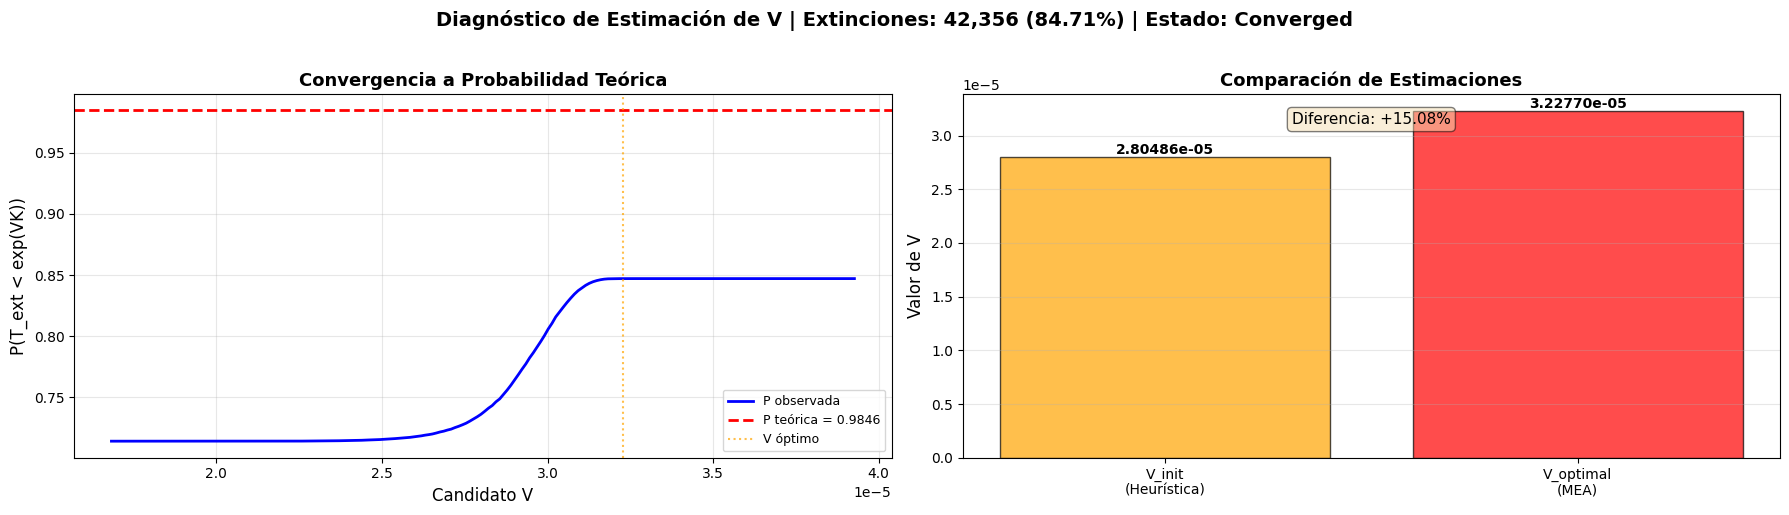

In [ ]:
# Visualizar diagnósticos
plot_V_estimation_diagnostics(results, save_path=filename_EV)

# Análisis estadístico
print(f"Tiempo medio de extinción: {results['mean_extinction_time']:.4e}")
print(f"V heurístico: {results['V_init_heuristic']:.6e}")
print(f"V optimizado: {results['V_estimated']:.6e}")
print(f"Mejora: {100*(results['V_error']):.2f}% de error")

### Estimacion de constante V
Para estimar los posibles valores de la constante $V$ vamos a hacer un barrido sobre valores de $K$ y $\theta$, luego haremos comparaciones

**Si quieres resultados más rápidos** para prototipar, cambia:
```python
N_TRAJECTORIES = 10_000  # En lugar de 30,000
```

**Si encuentras memoria insuficiente**, reduce el `batch_size`:
```python
times, finals = simulate_batch(
    subkey, N, x0, theta, alpha, K, T_max,
    batch_size=25_000  # En lugar de 50,000 por defecto
)
```



In [ ]:
def run_complete_experiment(
    thetas: List[float],
    alphas: List[float],
    K_values: List[float],
    N: int = 30_000,
    T_max: float = t_max,
    seed: int = 42
) -> Tuple[Dict, Dict, pd.DataFrame]:
    """
    Ejecuta el experimento completo de validación.

    Returns:
        Tupla con (simulation_results, analysis_results, summary_dataframe)
    """

    key = random.PRNGKey(seed)
    simulation_results = {}
    parameters = {}

    total_configs = len(thetas) * len(alphas) * len(K_values)
    current = 0

    print(f"\n{'='*80}")
    print(f"EXPERIMENTO DE VALIDACIÓN SISTEMÁTICA")
    print(f"{'='*80}")
    print(f"Configuraciones totales: {total_configs}")
    print(f"Trayectorias por configuración: {N:,}")
    print(f"Horizonte temporal: T_max = {T_max:.2e}")
    print(f"{'='*80}\n")

    start_total = time.time()

    for K in K_values:
        x0 = 1.0 / K

        for theta in thetas:
            for alpha in alphas:
                current += 1
                config_key = f"theta={theta}_alpha={alpha}_K={K:.0e}"

                print(f"[{current}/{total_configs}] {config_key}")

                key, subkey = random.split(key)
                start_sim = time.time()

                times, finals = simulate_batch(
                    subkey, N, x0, theta, alpha, K, T_max
                )

                elapsed_sim = time.time() - start_sim

                simulation_results[config_key] = (times, finals)
                parameters[config_key] = {'K': K, 'theta': theta, 'alpha': alpha}

                # Mostrar preview de resultados
                num_extinct = int(jnp.sum(finals == 0))
                print(f"  ✓ Simulación: {elapsed_sim:.1f}s | "
                      f"Extinciones: {num_extinct:,}/{N} ({100*num_extinct/N:.2f}%)")

    elapsed_total = time.time() - start_total
    print(f"\n{'='*80}")
    print(f"SIMULACIONES COMPLETADAS en {elapsed_total/60:.2f} minutos")
    print(f"{'='*80}\n")

    # Análisis de todos los resultados
    print("Iniciando análisis de V y validación asintótica...")
    analysis_results = batch_estimate_V(
        simulation_results,
        parameters,
        min_extinctions=50,
        grid_refinement=150,
        verbose=False
    )

    # Crear DataFrame resumen
    summary_data = []
    for key, result in analysis_results.items():
        if result['status'] not in ['Invalid_Input', 'Invalid_Data']:
            summary_data.append({
                'Config': key,
                'theta': result['theta'],
                'alpha': result['alpha'],
                'K': result['K'],
                'N_extinctions': result['num_extinctions'],
                'Extinction_Rate': result['extinction_rate'],
                'V_init': result['V_init_heuristic'],
                'V_optimal': result['V_estimated'],
                'V_error_MEA': result['V_error'],
                'T_mean': result['mean_extinction_time'],
                'P_theory': result['theoretical_prob'], # Corrected key
                'P_observed': result['P_asymptotic_observed'],
                'Asymptotic_Error': result['asymptotic_error'],
                'Status': result['status']
            })

    df_summary = pd.DataFrame(summary_data)

    return simulation_results, analysis_results, df_summary

In [ ]:
if __name__ == "__main__":

    print("\n" + "="*80)
    print("ANÁLISIS SISTEMÁTICO DE LA CONSTANTE V")
    print("Regímenes Superlineales con Variación de Ruido Aditivo")
    print("="*80)

    # Parámetros del experimento
    THETAS = [0.64, 1.0, 2.0]  # Superlineal, Logístico, Hiperlogístico
    ALPHAS = [100.0, 500.0, 1000.0]  # Ruido débil, moderado, fuerte
    K_VALUES = [1e4, 1e6]  # Capacidad pequeña y grande

    N_TRAJECTORIES = 30_000  # 30k trayectorias (ajusta según tu GPU)


    # Ejecutar experimento completo
    sim_results, analysis_results, summary_df = run_complete_experiment(
        thetas=THETAS,
        alphas=ALPHAS,
        K_values=K_VALUES,
        N=N_TRAJECTORIES,
        T_max=t_max, # Corrected from T_MAX to T_max
        seed=42
    )

    # Mostrar tabla resumen
    print("\n" + "="*80)
    print("TABLA RESUMEN DE RESULTADOS")
    print("="*80)

    # Configurar pandas para mejor visualización
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', lambda x: f'{x:.6e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.4f}')

    print(summary_df.to_string(index=False))

    # Guardar a CSV
    csv_filename = 'V_estimation_results.csv'
    summary_df.to_csv(csv_filename, index=False)
    print(f"\n✓ Resultados guardados en '{csv_filename}'")

    # Descargar CSV al navegador
    files.download(csv_filename)
    print(f"✓ '{csv_filename}' descargado al navegador.")


---

## Ejecucion de simulaciones para $\theta\le0$

In [ ]:
# 1. Ejecutar Experimento de regresion logaritmica
df_results, raw_times = run_sublinear_scaling_experiment(
    N_traj=N,          # Alta estadística
    base_t_max = t_max,
    K_values=[10, 100, 1000], # K values further reduced/adjusted
    thetas=[-0.5, -1.0],  # Casos sublineales
    alpha=1.0,         # Increased alpha significantly to promote extinctions
    seed=42
)


df_results_filename = 'sublinear_scaling_results.csv'
df_results.to_csv(df_results_filename, index=False)
print(f"\n✓ Resultados del escalamiento sublineal guardados en '{df_results_filename}'")
files.download(df_results_filename)
print(f"✓ '{df_results_filename}' descargado al navegador.")

# Procesar y guardar raw_times
raw_times_list = []
for (theta, K), times_extinct_array in raw_times.items():
    # Filtrar NaNs para evitar filas inútiles
    valid_times = times_extinct_array[~jnp.isnan(times_extinct_array)]
    for t in valid_times:
        raw_times_list.append({'theta': theta, 'K': K, 'extinction_time': t})

raw_times_df = pd.DataFrame(raw_times_list)

raw_times_filename = 'sublinear_raw_extinction_times.csv'
raw_times_df.to_csv(raw_times_filename, index=False)
print(f"\n✓ Tiempos de extinción crudos guardados en '{raw_times_filename}'")
files.download(raw_times_filename)
print(f"✓ '{raw_times_filename}' descargado al navegador.")

INICIANDO EXPERIMENTO DE ESCALAMIENTO SUBLINEAL (RTM)
Configuración: Alpha=1.0, Trayectorias=100

--> Procesando Theta = -0.5
   K=10 | T_mean=5.31e+01 | Extintos=100/100 | WallTime=1.29s
   [ALERTA] K=100: Pocas extinciones (9). Aumentar t_max.
   K=100 | T_mean=4.05e-02 | Extintos=9/100 | WallTime=282.81s
   [ALERTA] K=1000: Pocas extinciones (0). Aumentar t_max.
   K=1000 | T_mean=nan | Extintos=0/100 | WallTime=282.95s
--> Procesando Theta = -1.0
   K=10 | T_mean=4.32e+03 | Extintos=100/100 | WallTime=24.63s
   [ALERTA] K=100: Pocas extinciones (3). Aumentar t_max.
   K=100 | T_mean=1.31e-02 | Extintos=3/100 | WallTime=283.34s
   [ALERTA] K=1000: Pocas extinciones (0). Aumentar t_max.
   K=1000 | T_mean=nan | Extintos=0/100 | WallTime=281.80s

✓ Resultados del escalamiento sublineal guardados en 'sublinear_scaling_results.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ 'sublinear_scaling_results.csv' descargado al navegador.

✓ Tiempos de extinción crudos guardados en 'sublinear_raw_extinction_times.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ 'sublinear_raw_extinction_times.csv' descargado al navegador.


### Analisis

In [ ]:
# Cargar los resultados de escalamiento sublineal y raw desde el archivo CSV
try:
    df_results = pd.read_csv('sublinear_scaling_results.csv')
    raw_times = pd.read_csv('sublinear_raw_extinction_times.csv')
    print("Archivo 'sublinear_raw_extinction_times.csv' cargado exitosamente.")
    print("Archivo 'sublinear_scaling_results.csv' cargado exitosamente.")
except FileNotFoundError:
    print("Error: El archivo 'sublinear_scaling_results.csv' no se encontró.")
    print("Por favor, asegórate de que el experimento de escalamiento sublineal se haya ejecutado correctamente y guardado los resultados.")
    df_results = pd.DataFrame() # Crear un DataFrame vacío para evitar errores posteriores

    print("Error: El archivo 'sublinear_raw_extinction_times.csv' no se encontró.")
    print("Por favor, asegórate de que el experimento de escalamiento sublineal se haya ejecutado correctamente y guardado los tiempos crudos.")
    raw_times = pd.DataFrame({'theta': [], 'K': [], 'extinction_time': []})


Archivo 'sublinear_raw_extinction_times.csv' cargado exitosamente.
Archivo 'sublinear_scaling_results.csv' cargado exitosamente.


In [ ]:
# Reconstruir el diccionario raw_times para las funciones de verificación
raw_data_reconstructed = {}
if not raw_times.empty:
    for (theta, K), group in raw_times.groupby(['theta', 'K']):
        raw_data_reconstructed[(float(theta), int(K))] = jnp.array(group['extinction_time'].values)

# --- INICIO DE MODIFICACIONES SUGERIDAS ---

# 1. Selecciona el par (theta, K) para el que deseas realizar las verificaciones
theta_to_verify = -0.5
K_for_verification = 10000 # Puedes cambiar este K a 100 o 10000 según tu interés

if not df_V_estimates_per_pair.empty:
    # Filtra el DataFrame para obtener la estimación de V para el (theta, K) seleccionado
    selected_V_row = df_V_estimates_per_pair[
        (df_V_estimates_per_pair['theta'] == theta_to_verify) &
        (df_V_estimates_per_pair['K'] == K_for_verification)
    ]

    if not selected_V_row.empty:
        V_est = selected_V_row['V_refined'].iloc[0]

        print(f"Usando V_est = {V_est:.5e} para theta={theta_to_verify}, K={K_for_verification}")

        # Asegúrate de que raw_data_reconstructed contenga los datos para este (theta, K)
        if (theta_to_verify, K_for_verification) in raw_data_reconstructed:

            # 2. Test de Metaestabilidad (verify_metastability)
            verify_metastability(raw_data_reconstructed, theta_to_verify, K_for_verification)


        else:
            print(f"No hay datos crudos para el par (theta={theta_to_verify}, K={K_for_verification}) para la verificación.")
    else:
        print(f"No se encontró estimación de V en df_V_estimates_per_pair para theta={theta_to_verify}, K={K_for_verification}")
else:
    print("No hay datos cargados o generados para realizar la verificación (df_V_estimates_per_pair está vacío).")

